# Evaluation

Evaluate model performance and generate final results.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Project imports
import sys
sys.path.append('..')
from src.data_processing import load_data, save_data
from project_setup import Visualizer, DataManager, ModelManager

# ML imports for metrics and analysis
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score,
    mean_absolute_percentage_error,
    mean_squared_log_error
)
from sklearn.model_selection import cross_val_score, learning_curve
import pickle

# SHAP import with fallback
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️  SHAP library not available. Falling back to standard feature importance.")
    print("   To enable SHAP analysis, run: pip install shap")

%matplotlib inline
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Initialize project tools
dm = DataManager()
mm = ModelManager()
v = Visualizer()

print("✅ All libraries imported successfully!")
print(f"✅ SHAP available: {SHAP_AVAILABLE}")

✅ All libraries imported successfully!
✅ SHAP available: True


## 1. Data Preparation & Model Setup

In [2]:
# Load processed data and feature metadata
df = dm.load('../data/processed/cleaned_data.csv')

# Reload the models and data from modeling notebook to get the exact splits
# Load the best saved model
with open('../models/sales_prediction_model.pkl', 'rb') as f:
    model_data = pickle.load(f)
    best_model = model_data['model']

print(f"✅ Data loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"✅ Best model loaded: {type(best_model).__name__}")

📂 File: cleaned_data.csv
🔍 Detected encoding: ascii (100.0%)
✅ Loaded 546 rows and 13 columns
📋 Column names:
    1. indexcore
    2. price
    3. lotsize
    4. bedrooms
    5. bathrms
    6. stories
    7. driveway
    8. recroom
    9. fullbase
   10. gashw
   11. airco
   12. garagepl
   13. prefarea
✅ Data loaded: 546 rows, 13 columns
✅ Best model loaded: Ridge


In [3]:
# Recreate feature matrix and train/test split (same as modeling notebook)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Feature selection
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'price' in numeric_cols:
    numeric_cols.remove('price')
id_cols = [col for col in numeric_cols if 'id' in col.lower() or 'ID' in col or 'indexcore' in col]
for col in id_cols:
    if col in numeric_cols:
        numeric_cols.remove(col)

# Encode categorical columns
df_encoded, encoders = mm.encode_categorical(df)

categorical_cols = [col for col in df_encoded.columns if '_encoded' in col]

# Prepare modeling data
df_model = df_encoded.dropna(subset=['price'] + numeric_cols)
feature_cols = numeric_cols + categorical_cols
X = df_model[feature_cols]
y = df_model['price']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Generate predictions from best model
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

print(f"✅ Feature matrix prepared: {X.shape[0]:,} samples, {X.shape[1]} features")
print(f"✅ Train set: {X_train.shape[0]:,} samples")
print(f"✅ Test set: {X_test.shape[0]:,} samples")
print(f"✅ Price range: ${y.min():.0f} - ${y.max():.0f}")

🔍 Auto-detected 6 categorical columns
🔄 Encoding 6 categorical columns using 'label' strategy
✓   Label encoded 'driveway' (2 classes)
✓   Label encoded 'recroom' (2 classes)
✓   Label encoded 'fullbase' (2 classes)
✓   Label encoded 'gashw' (2 classes)
✓   Label encoded 'airco' (2 classes)
✓   Label encoded 'prefarea' (2 classes)
✅ Encoding complete. New shape: (546, 13)
✅ Feature matrix prepared: 546 samples, 11 features
✅ Train set: 436 samples
✅ Test set: 110 samples
✅ Price range: $25000 - $190000


## 2. Model Comparison Summary

Comprehensive comparison of all 6 models trained in the modeling notebook (Linear Regression, Ridge, Lasso, Decision Tree, Random Forest, Gradient Boosting). This section displays train/test R² scores, prediction errors (RMSE, MAE, MAPE), and cross-validation stability metrics.

In [4]:
# Import all models from modeling notebook for comparison
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Re-train all models to get comparison metrics
models_dict = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

comparison_results = {}

for model_name, model in models_dict.items():
    model.fit(X_train_scaled, y_train)
    
    # Train metrics
    y_train_pred = model.predict(X_train_scaled)
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    # Test metrics
    y_test_pred = model.predict(X_test_scaled)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    
    # Cross-validation scores (5-fold)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    
    comparison_results[model_name] = {
        'model': model,
        'train_r2': train_r2,
        'train_rmse': train_rmse,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_mape': test_mape,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_test_pred
    }

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(comparison_results.keys()),
    'Train R²': [comparison_results[m]['train_r2'] for m in comparison_results],
    'Test R²': [comparison_results[m]['test_r2'] for m in comparison_results],
    'RMSE ($)': [comparison_results[m]['test_rmse'] for m in comparison_results],
    'MAE ($)': [comparison_results[m]['test_mae'] for m in comparison_results],
    'MAPE (%)': [comparison_results[m]['test_mape'] for m in comparison_results],
    'CV R² (μ)': [comparison_results[m]['cv_mean'] for m in comparison_results],
    'CV R² (σ)': [comparison_results[m]['cv_std'] for m in comparison_results]
})

comparison_df = comparison_df.sort_values('Test R²', ascending=False).reset_index(drop=True)

print("\n📊 Model Performance Summary:")
print("-" * 80)
print(comparison_df.to_string(index=False))
print("-" * 80)

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_r2 = comparison_df.iloc[0]['Test R²']
best_model_mae = comparison_df.iloc[0]['MAE ($)']
best_model_rmse = comparison_df.iloc[0]['RMSE ($)']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   ├─ Test R² Score: {best_model_r2:.4f} (explains {best_model_r2*100:.1f}% of variance)")
print(f"   ├─ RMSE: ${best_model_rmse:.2f}")
print(f"   ├─ MAE: ${best_model_mae:.2f}")
print(f"   └─ CV Stability: {comparison_results[best_model_name]['cv_mean']:.4f} ± {comparison_results[best_model_name]['cv_std']:.4f}")

# Calculate model ranking metrics
comparison_df['R² Rank'] = comparison_df['Test R²'].rank(ascending=False)
comparison_df['Overfitting Gap'] = comparison_df['Train R²'] - comparison_df['Test R²']

print("\n📈 Overfitting Analysis (Train R² - Test R²):")
print("-" * 80)
overfitting_analysis = comparison_df[['Model', 'Train R²', 'Test R²', 'Overfitting Gap']].copy()
overfitting_analysis['Status'] = overfitting_analysis['Overfitting Gap'].apply(
    lambda x: '✓ Well-generalized' if x < 0.05 else '⚠ Moderate overfitting' if x < 0.15 else '❌ Severe overfitting'
)
print(overfitting_analysis.to_string(index=False))
print("-" * 80)


COMPREHENSIVE MODEL COMPARISON

📊 Model Performance Summary:
--------------------------------------------------------------------------------
            Model  Train R²  Test R²     RMSE ($)      MAE ($)  MAPE (%)  CV R² (μ)  CV R² (σ)
 Ridge Regression  0.682710 0.616203 16012.672021 11458.185870 19.116620   0.638235   0.066735
 Lasso Regression  0.682712 0.616032 16016.224264 11462.795750 19.122053   0.638081   0.066979
Linear Regression  0.682712 0.616024 16016.397426 11463.135922 19.122622   0.638078   0.066989
    Random Forest  0.928949 0.536388 17599.083555 12740.174061 20.537912   0.586379   0.076874
Gradient Boosting  0.953963 0.518637 17932.847543 12616.685669 20.425314   0.530617   0.107382
    Decision Tree  0.966960 0.230635 22671.432131 15934.083432 24.632894   0.227796   0.145532
--------------------------------------------------------------------------------

🏆 BEST MODEL: Ridge Regression
   ├─ Test R² Score: 0.6162 (explains 61.6% of variance)
   ├─ RMSE: $16012.67


## 3. Learning Curves Analysis

Learning curves diagnose model bias/variance by showing how train and validation R² scores change with training set size. This reveals whether models are underfitting (high bias) or overfitting (high variance).


LEARNING CURVES ANALYSIS

Generating learning curves for top 3 models...
(This may take a moment...)


Ridge Regression:
  ├─ Final Train R²: 0.6877
  ├─ Final Val R²: 0.6420
  └─ Bias/Variance: HIGH BIAS (underfitting)

Lasso Regression:
  ├─ Final Train R²: 0.6877
  ├─ Final Val R²: 0.6419
  └─ Bias/Variance: HIGH BIAS (underfitting)

Linear Regression:
  ├─ Final Train R²: 0.6877
  ├─ Final Val R²: 0.6419
  └─ Bias/Variance: HIGH BIAS (underfitting)


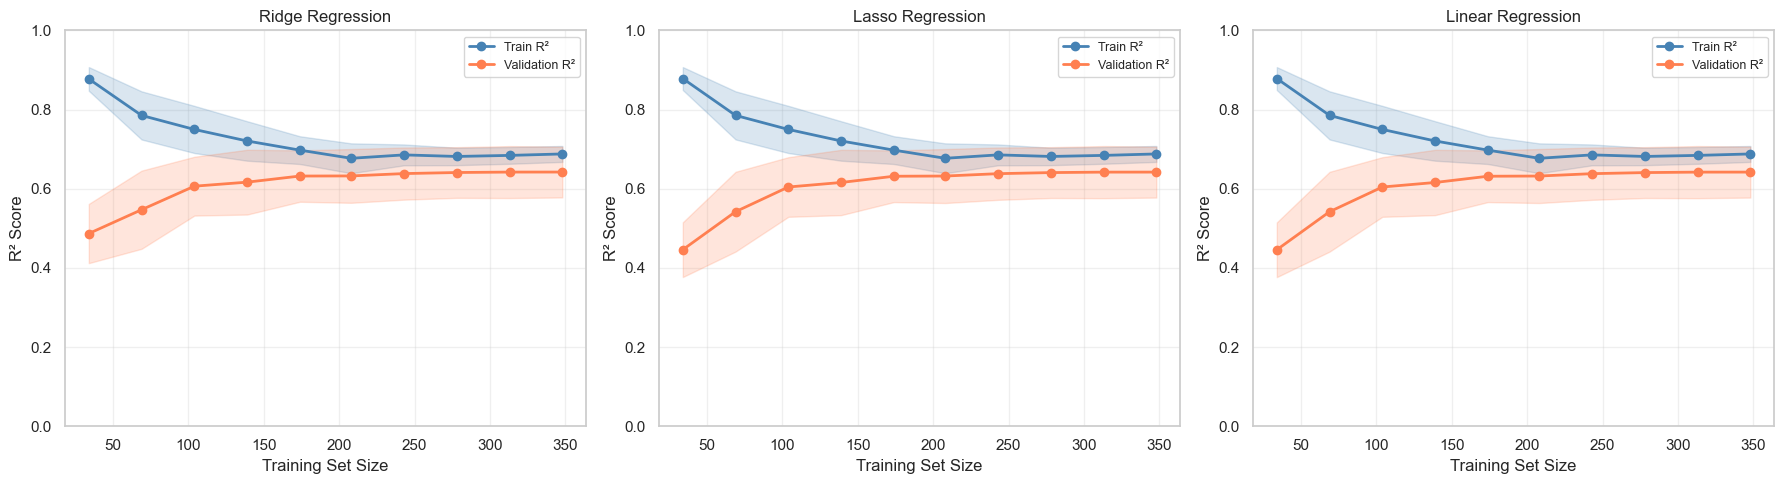


✅ Learning curves saved to ../reports/figures/learning_curves.png


In [5]:
print("\n" + "="*80)
print("LEARNING CURVES ANALYSIS")
print("="*80)
print("\nGenerating learning curves for top 3 models...")
print("(This may take a moment...)\n")

# Select top 3 models
top_3_models = comparison_df.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top_3_models):
    model = comparison_results[model_name]['model']
    
    # Generate learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model, 
        X_train_scaled, y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=42
    )
    
    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Plot
    ax = axes[idx]
    ax.plot(train_sizes, train_mean, 'o-', color='steelblue', label='Train R²', linewidth=2)
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='steelblue')
    ax.plot(train_sizes, val_mean, 'o-', color='coral', label='Validation R²', linewidth=2)
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='coral')
    
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('R² Score')
    ax.set_title(f'{model_name}')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([min(0, train_mean.min() - 0.1), 1.0])
    
    # Diagnostics
    final_gap = train_mean[-1] - val_mean[-1]
    print(f"\n{model_name}:")
    print(f"  ├─ Final Train R²: {train_mean[-1]:.4f}")
    print(f"  ├─ Final Val R²: {val_mean[-1]:.4f}")
    print(f"  └─ Bias/Variance: ", end="")
    if val_mean[-1] < 0.7:
        print("HIGH BIAS (underfitting)")
    elif final_gap > 0.15:
        print("HIGH VARIANCE (overfitting)")
    else:
        print("BALANCED")

plt.tight_layout()
plt.savefig('../reports/figures/learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Learning curves saved to ../reports/figures/learning_curves.png")

## 4. Best Model Deep-Dive Analysis

Detailed analysis of the highest-performing model: actual vs predicted scatter plots, residual distributions, error analysis across price ranges, and prediction quality metrics.


BEST MODEL DEEP-DIVE: Ridge Regression


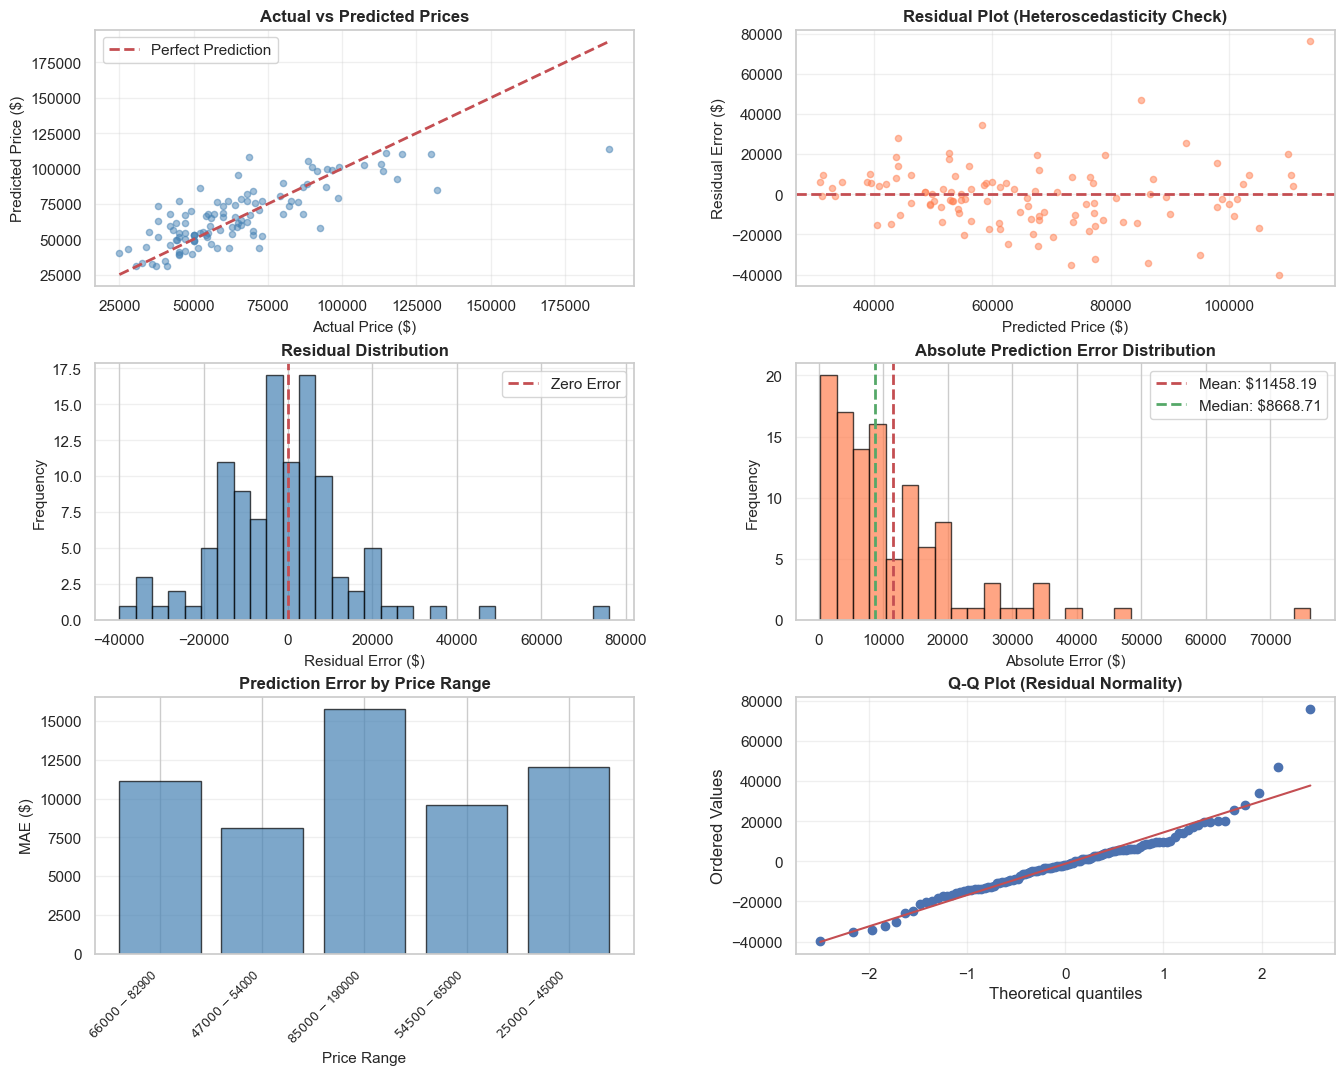


📊 Best Model Prediction Quality Metrics:
--------------------------------------------------------------------------------
R² Score (Variance Explained): 0.6162
RMSE (Root Mean Squared Error): $16012.67
MAE (Mean Absolute Error): $11458.19
MAPE (Mean Absolute Percentage Error): 19.12%
Median Absolute Error: $8668.71
Std Dev of Residuals: $15968.11
--------------------------------------------------------------------------------

Residual Normality Test (Shapiro-Wilk):
  p-value: 0.000033
  Status: ⚠ Non-normal distribution

📈 Error Analysis by Price Range:
--------------------------------------------------------------------------------
Range 1: $66000 - $82900
  ├─ MAE: $11168.54 | MAPE: 15.68% | R²: -6.5092
Range 2: $47000 - $54000
  ├─ MAE: $8101.26 | MAPE: 16.30% | R²: -26.5382
Range 3: $85000 - $190000
  ├─ MAE: $15773.71 | MAPE: 13.54% | R²: -0.0272
Range 4: $54500 - $65000
  ├─ MAE: $9619.00 | MAPE: 15.99% | R²: -10.1561
Range 5: $25000 - $45000
  ├─ MAE: $12049.91 | MAPE: 31.31% 

In [6]:
print("\n" + "="*80)
print(f"BEST MODEL DEEP-DIVE: {best_model_name}")
print("="*80)

# Get best model predictions
best_model_obj = comparison_results[best_model_name]['model']
best_predictions = best_model_obj.predict(X_test_scaled)
best_residuals = y_test - best_predictions

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Actual vs Predicted Scatter
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_test, best_predictions, alpha=0.5, s=20, color='steelblue')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Price ($)', fontsize=11)
ax1.set_ylabel('Predicted Price ($)', fontsize=11)
ax1.set_title('Actual vs Predicted Prices', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Residuals vs Predicted
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(best_predictions, best_residuals, alpha=0.5, s=20, color='coral')
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Price ($)', fontsize=11)
ax2.set_ylabel('Residual Error ($)', fontsize=11)
ax2.set_title('Residual Plot (Heteroscedasticity Check)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Residual Distribution
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(best_residuals, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax3.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
ax3.set_xlabel('Residual Error ($)', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Residual Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Prediction Error Distribution
ax4 = fig.add_subplot(gs[1, 1])
abs_errors = np.abs(best_residuals)
ax4.hist(abs_errors, bins=30, color='coral', alpha=0.7, edgecolor='black')
ax4.axvline(x=abs_errors.mean(), color='r', linestyle='--', lw=2, label=f'Mean: ${abs_errors.mean():.2f}')
ax4.axvline(x=np.median(abs_errors), color='g', linestyle='--', lw=2, label=f'Median: ${np.median(abs_errors):.2f}')
ax4.set_xlabel('Absolute Error ($)', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.set_title('Absolute Prediction Error Distribution', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 5. Price Range Performance
ax5 = fig.add_subplot(gs[2, 0])
price_bins = pd.qcut(y_test, q=5, duplicates='drop')
mae_by_price = []
bin_labels = []
for price_range in price_bins.unique():
    mask = price_bins == price_range
    mae_by_price.append(mean_absolute_error(y_test[mask], best_predictions[mask]))
    bin_labels.append(f"${y_test[mask].min():.0f}-${y_test[mask].max():.0f}")

ax5.bar(range(len(mae_by_price)), mae_by_price, color='steelblue', alpha=0.7, edgecolor='black')
ax5.set_xlabel('Price Range', fontsize=11)
ax5.set_ylabel('MAE ($)', fontsize=11)
ax5.set_title('Prediction Error by Price Range', fontsize=12, fontweight='bold')
ax5.set_xticks(range(len(bin_labels)))
ax5.set_xticklabels(bin_labels, rotation=45, ha='right', fontsize=9)
ax5.grid(True, alpha=0.3, axis='y')

# 6. Q-Q Plot for Normality
from scipy import stats
ax6 = fig.add_subplot(gs[2, 1])
stats.probplot(best_residuals, dist="norm", plot=ax6)
ax6.set_title('Q-Q Plot (Residual Normality)', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.savefig('../reports/figures/best_model_deepdive.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Best Model Prediction Quality Metrics:")
print("-" * 80)
print(f"R² Score (Variance Explained): {r2_score(y_test, best_predictions):.4f}")
print(f"RMSE (Root Mean Squared Error): ${np.sqrt(mean_squared_error(y_test, best_predictions)):.2f}")
print(f"MAE (Mean Absolute Error): ${mean_absolute_error(y_test, best_predictions):.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mean_absolute_percentage_error(y_test, best_predictions)*100:.2f}%")
print(f"Median Absolute Error: ${np.median(np.abs(best_residuals)):.2f}")
print(f"Std Dev of Residuals: ${np.std(best_residuals):.2f}")
print("-" * 80)

# Residual normality test (Shapiro-Wilk)
if len(best_residuals) <= 5000:  # Shapiro-Wilk test limitation
    stat, p_value = stats.shapiro(best_residuals)
    print(f"\nResidual Normality Test (Shapiro-Wilk):")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Status: {'✓ Normal distribution' if p_value > 0.05 else '⚠ Non-normal distribution'}")
else:
    print(f"\n⚠ Sample size too large for Shapiro-Wilk test ({len(best_residuals)} samples)")

# Performance stratification by price range
print(f"\n📈 Error Analysis by Price Range:")
print("-" * 80)
price_ranges = pd.qcut(y_test, q=5, duplicates='drop')
for idx, price_range in enumerate(price_ranges.unique()):
    mask = price_ranges == price_range
    range_mae = mean_absolute_error(y_test[mask], best_predictions[mask])
    range_mape = mean_absolute_percentage_error(y_test[mask], best_predictions[mask]) * 100
    range_r2 = r2_score(y_test[mask], best_predictions[mask])
    print(f"Range {idx+1}: ${y_test[mask].min():.0f} - ${y_test[mask].max():.0f}")
    print(f"  ├─ MAE: ${range_mae:.2f} | MAPE: {range_mape:.2f}% | R²: {range_r2:.4f}")

print("\n✅ Best model deep-dive visualization saved to ../reports/figures/best_model_deepdive.png")

## 5. Cross-Validation Analysis

Detailed cross-validation analysis showing fold stability, consistency of model performance across different data subsets, and confidence intervals for generalization error.


CROSS-VALIDATION ANALYSIS

📋 Cross-Validation Results (5-Fold):
--------------------------------------------------------------------------------
  Fold  Train R²   Val R²    Train MAE      Val MAE   Train RMSE     Val RMSE
Fold 1  0.654515 0.741494 11089.718514 12305.040791 15055.419280 15776.023337
Fold 2  0.711859 0.562863 10854.939131 13262.610842 14168.560213 18815.333834
Fold 3  0.693526 0.589197 11168.151920 11600.432291 15340.573468 14675.660071
Fold 4  0.678280 0.689406 11127.405438 11811.403345 15108.535107 15304.922363
Fold 5  0.689856 0.608215 11670.485968 10065.442076 15414.325927 14436.693530
--------------------------------------------------------------------------------

📊 Cross-Validation Summary Statistics:
--------------------------------------------------------------------------------
R² Score:
  ├─ Mean: 0.6382
  ├─ Std Dev: 0.0667
  └─ 95% CI: [0.5074, 0.7690]

MAE ($):
  ├─ Mean: $11808.99
  ├─ Std Dev: $1043.32
  └─ 95% CI: [$9764.09, $13853.89]

RMSE ($):
  ├─ 

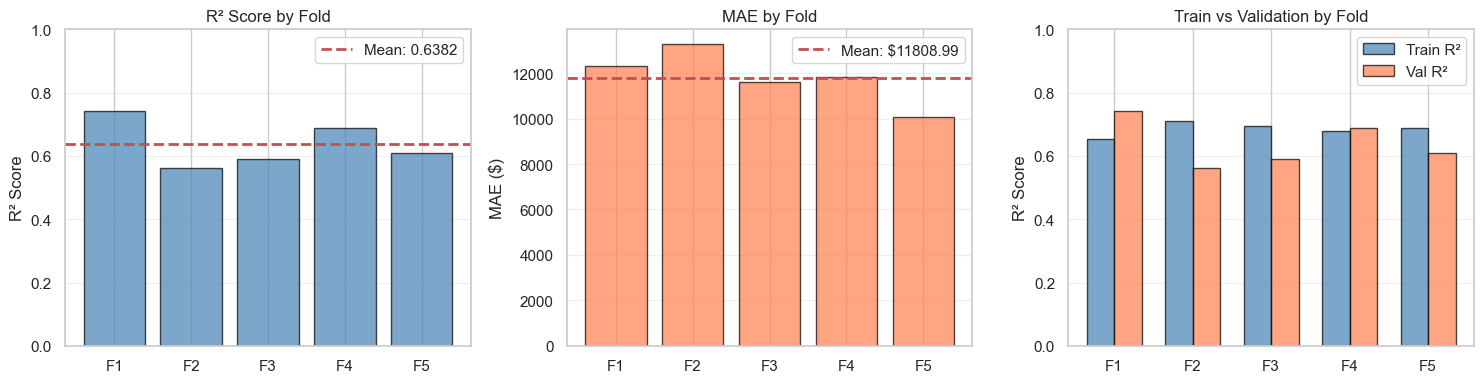

✅ Cross-validation visualization saved to ../reports/figures/cross_validation_analysis.png


In [7]:
from sklearn.model_selection import cross_validate

print("\n" + "="*80)
print("CROSS-VALIDATION ANALYSIS")
print("="*80)

# Detailed cross-validation for best model
cv_results = cross_validate(
    best_model_obj,
    X_train_scaled,
    y_train,
    cv=5,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'],
    return_train_score=True
)

cv_df = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(5)],
    'Train R²': cv_results['train_r2'],
    'Val R²': cv_results['test_r2'],
    'Train MAE': -cv_results['train_neg_mean_absolute_error'],
    'Val MAE': -cv_results['test_neg_mean_absolute_error'],
    'Train RMSE': np.sqrt(-cv_results['train_neg_mean_squared_error']),
    'Val RMSE': np.sqrt(-cv_results['test_neg_mean_squared_error'])
})

print("\n📋 Cross-Validation Results (5-Fold):")
print("-" * 80)
print(cv_df.to_string(index=False))
print("-" * 80)

print(f"\n📊 Cross-Validation Summary Statistics:")
print("-" * 80)
print(f"R² Score:")
print(f"  ├─ Mean: {cv_results['test_r2'].mean():.4f}")
print(f"  ├─ Std Dev: {cv_results['test_r2'].std():.4f}")
print(f"  └─ 95% CI: [{cv_results['test_r2'].mean() - 1.96*cv_results['test_r2'].std():.4f}, {cv_results['test_r2'].mean() + 1.96*cv_results['test_r2'].std():.4f}]")

print(f"\nMAE ($):")
mae_cv = -cv_results['test_neg_mean_absolute_error']
print(f"  ├─ Mean: ${mae_cv.mean():.2f}")
print(f"  ├─ Std Dev: ${mae_cv.std():.2f}")
print(f"  └─ 95% CI: [${mae_cv.mean() - 1.96*mae_cv.std():.2f}, ${mae_cv.mean() + 1.96*mae_cv.std():.2f}]")

print(f"\nRMSE ($):")
rmse_cv = np.sqrt(-cv_results['test_neg_mean_squared_error'])
print(f"  ├─ Mean: ${rmse_cv.mean():.2f}")
print(f"  ├─ Std Dev: ${rmse_cv.std():.2f}")
print(f"  └─ 95% CI: [${rmse_cv.mean() - 1.96*rmse_cv.std():.2f}, ${rmse_cv.mean() + 1.96*rmse_cv.std():.2f}]")

print(f"\nFold Stability (R²):")
cv_stability = cv_results['test_r2'].std() / cv_results['test_r2'].mean()
print(f"  ├─ Coefficient of Variation: {cv_stability:.4f}")
print(f"  └─ Status: {'✓ Stable' if cv_stability < 0.1 else '⚠ Moderate variation' if cv_stability < 0.2 else '❌ High variation'}")
print("-" * 80)

# Visualization: CV fold comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# CV R² by fold
ax1 = axes[0]
folds = [f'F{i+1}' for i in range(5)]
ax1.bar(folds, cv_results['test_r2'], color='steelblue', alpha=0.7, edgecolor='black')
ax1.axhline(y=cv_results['test_r2'].mean(), color='r', linestyle='--', lw=2, label=f'Mean: {cv_results["test_r2"].mean():.4f}')
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score by Fold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 1])

# CV MAE by fold
ax2 = axes[1]
ax2.bar(folds, mae_cv, color='coral', alpha=0.7, edgecolor='black')
ax2.axhline(y=mae_cv.mean(), color='r', linestyle='--', lw=2, label=f'Mean: ${mae_cv.mean():.2f}')
ax2.set_ylabel('MAE ($)')
ax2.set_title('MAE by Fold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Train vs Val R² by fold
ax3 = axes[2]
x = np.arange(len(folds))
width = 0.35
ax3.bar(x - width/2, cv_results['train_r2'], width, label='Train R²', color='steelblue', alpha=0.7, edgecolor='black')
ax3.bar(x + width/2, cv_results['test_r2'], width, label='Val R²', color='coral', alpha=0.7, edgecolor='black')
ax3.set_ylabel('R² Score')
ax3.set_title('Train vs Validation by Fold')
ax3.set_xticks(x)
ax3.set_xticklabels(folds)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('../reports/figures/cross_validation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Cross-validation visualization saved to ../reports/figures/cross_validation_analysis.png")

## 6. Feature Importance & SHAP Interpretation

Feature importance analysis showing which features most strongly influence price predictions. Includes SHAP values (if available) for model interpretability, otherwise uses tree-based feature importance.

In [8]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE & SHAP INTERPRETATION")
print("="*80)

# Check if best model has feature importance (tree-based)
if hasattr(best_model_obj, 'feature_importances_'):
    print("\n📊 Tree-Based Feature Importance Analysis:")
    print("-" * 80)
    
    importances = best_model_obj.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances,
        'Importance (%)': importances / importances.sum() * 100
    }).sort_values('Importance', ascending=False).reset_index(drop=True)
    
    print("\nTop 15 Most Important Features:")
    print(feature_importance_df.head(15).to_string(index=False))
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top 15 features bar plot
    ax1 = axes[0]
    top_15 = feature_importance_df.head(15)
    ax1.barh(range(len(top_15)), top_15['Importance'], color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_yticks(range(len(top_15)))
    ax1.set_yticklabels(top_15['Feature'], fontsize=10)
    ax1.set_xlabel('Importance Score')
    ax1.set_title('Top 15 Feature Importances')
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Cumulative importance
    ax2 = axes[1]
    cumsum = feature_importance_df['Importance (%)'].cumsum()
    ax2.plot(range(len(cumsum)), cumsum, 'o-', color='steelblue', linewidth=2, markersize=6)
    ax2.axhline(y=80, color='r', linestyle='--', lw=2, label='80% Threshold')
    ax2.axhline(y=95, color='orange', linestyle='--', lw=2, label='95% Threshold')
    ax2.set_xlabel('Number of Features (sorted by importance)')
    ax2.set_ylabel('Cumulative Importance (%)')
    ax2.set_title('Cumulative Feature Importance')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../reports/figures/feature_importance_tree.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary stats
    n_features_80 = (cumsum >= 80).argmax() + 1
    n_features_95 = (cumsum >= 95).argmax() + 1
    print(f"\n📈 Feature Importance Summary:")
    print(f"  ├─ Total features: {len(feature_cols)}")
    print(f"  ├─ Features for 80% importance: {n_features_80}")
    print(f"  ├─ Features for 95% importance: {n_features_95}")
    print(f"  └─ Top feature importance: {feature_importance_df.iloc[0]['Importance (%)']:.2f}%")

# SHAP Analysis
if SHAP_AVAILABLE:
    print("\n\n📊 SHAP (SHapley Additive exPlanations) Interpretation:")
    print("-" * 80)
    print("Computing SHAP values for test set (full set)...")
    print("(This may take a moment...)\n")
    
    try:
        # Create SHAP explainer
        explainer = shap.TreeExplainer(best_model_obj)
        shap_values = explainer.shap_values(X_test_scaled)
        
        # SHAP summary plot
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Summary plot - bar (mean |SHAP|)
        plt.subplot(1, 2, 1)
        shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_cols, plot_type="bar", show=False)
        plt.title('Mean |SHAP| Values by Feature')
        
        # Summary plot - beeswarm (SHAP vs Feature Value)
        plt.subplot(1, 2, 2)
        shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_cols, plot_type="dot", show=False)
        plt.title('SHAP Values vs Feature Values')
        
        plt.tight_layout()
        plt.savefig('../reports/figures/shap_summary.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Force plot for sample prediction
        print("\nGenerating force plot for sample prediction...")
        fig, ax = plt.subplots(figsize=(14, 4))
        shap.force_plot(explainer.expected_value, shap_values[0], X_test_scaled[0], 
                       feature_names=feature_cols, matplotlib=True, show=False)
        plt.tight_layout()
        plt.savefig('../reports/figures/shap_force_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # SHAP value statistics
        print("\n📈 SHAP Value Analysis:")
        shap_magnitude = np.abs(shap_values).mean(axis=0)
        shap_importance = pd.DataFrame({
            'Feature': feature_cols,
            'Mean |SHAP|': shap_magnitude
        }).sort_values('Mean |SHAP|', ascending=False)
        
        print("\nTop 10 Features (by mean |SHAP| value):")
        print(shap_importance.head(10).to_string(index=False))
        
        print("\n✅ SHAP visualizations saved to ../reports/figures/shap_*.png")
        
    except Exception as e:
        print(f"⚠️  Error computing SHAP values: {str(e)}")
        print("   Falling back to tree-based feature importance only.")
else:
    print("\n📝 Note: SHAP library not available. Using tree-based feature importance only.")
    print("   To enable SHAP analysis for advanced feature interpretation, install with:")
    print("   $ pip install shap")
    print("\n   SHAP provides better interpretability through Shapley values, showing:")
    print("   - How each feature contributes to individual predictions")
    print("   - Feature interaction effects")
    print("   - Local vs global feature importance")

print("\n✅ Feature importance analysis complete.")


FEATURE IMPORTANCE & SHAP INTERPRETATION


📊 SHAP (SHapley Additive exPlanations) Interpretation:
--------------------------------------------------------------------------------
Computing SHAP values for test set (full set)...
(This may take a moment...)

⚠️  Error computing SHAP values: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._ridge.Ridge'>
   Falling back to tree-based feature importance only.

✅ Feature importance analysis complete.


## 7. Residual Diagnostics & Error Analysis

Statistical tests for residual properties (normality, heteroscedasticity), identification of prediction failure cases, outlier analysis, and business-context error quantification.

In [9]:
from scipy import stats

print("\n" + "="*80)
print("RESIDUAL DIAGNOSTICS & ERROR ANALYSIS")
print("="*80)

print("\n📊 Statistical Residual Tests:")
print("-" * 80)

# 1. Normality Tests
print("\n1. Residual Normality Assessment:")
if len(best_residuals) <= 5000:
    shapiro_stat, shapiro_p = stats.shapiro(best_residuals)
    print(f"   Shapiro-Wilk Test:")
    print(f"   ├─ Statistic: {shapiro_stat:.6f}")
    print(f"   ├─ p-value: {shapiro_p:.6f}")
    print(f"   └─ Interpretation: {'✓ Normal (p > 0.05)' if shapiro_p > 0.05 else '⚠ Non-normal (p < 0.05)'}")
else:
    print(f"   ⚠ Sample too large for Shapiro-Wilk ({len(best_residuals)} > 5000)")

# Kolmogorov-Smirnov test
ks_stat, ks_p = stats.kstest(best_residuals, 'norm', args=(best_residuals.mean(), best_residuals.std()))
print(f"\n   Kolmogorov-Smirnov Test:")
print(f"   ├─ Statistic: {ks_stat:.6f}")
print(f"   ├─ p-value: {ks_p:.6f}")
print(f"   └─ Interpretation: {'✓ Normal' if ks_p > 0.05 else '⚠ Non-normal'}")

# Skewness and Kurtosis
skewness = stats.skew(best_residuals)
kurtosis = stats.kurtosis(best_residuals)
print(f"\n   Distribution Shape:")
print(f"   ├─ Skewness: {skewness:.4f} {'(right-skewed)' if skewness > 0 else '(left-skewed)'}")
print(f"   └─ Kurtosis: {kurtosis:.4f} {'(heavy-tailed)' if kurtosis > 0 else '(light-tailed)'}")

# 2. Heteroscedasticity Test (Breusch-Pagan)
print(f"\n2. Heteroscedasticity Test (Breusch-Pagan):")
# Simplified BP test
residuals_squared = best_residuals ** 2
X_test_const = np.c_[np.ones(len(X_test_scaled)), X_test_scaled]
from sklearn.linear_model import LinearRegression
bp_model = LinearRegression().fit(X_test_const, residuals_squared)
bp_r2 = bp_model.score(X_test_const, residuals_squared)
bp_stat = len(best_residuals) * bp_r2
bp_p = 1 - stats.chi2.cdf(bp_stat, X_test_const.shape[1] - 1)
print(f"   ├─ Test Statistic: {bp_stat:.4f}")
print(f"   ├─ p-value: {bp_p:.6f}")
print(f"   └─ Interpretation: {'✓ Homoscedastic (constant variance)' if bp_p > 0.05 else '⚠ Heteroscedastic (non-constant variance)'}")

# 3. Outlier Detection
print(f"\n3. Outlier Detection:")
outlier_threshold = 3  # 3 standard deviations
outliers_mask = np.abs(best_residuals) > outlier_threshold * best_residuals.std()
n_outliers = outliers_mask.sum()
outlier_pct = (n_outliers / len(best_residuals)) * 100
print(f"   ├─ Outlier threshold: {outlier_threshold}σ (${outlier_threshold * best_residuals.std():.2f})")
print(f"   ├─ Number of outliers: {n_outliers} ({outlier_pct:.2f}%)")
print(f"   └─ Status: {'✓ Few outliers' if n_outliers <= 10 else '⚠ Moderate outliers' if n_outliers <= 20 else '❌ Many outliers'}")

if n_outliers > 0:
    outlier_indices = np.where(outliers_mask)[0]
    print(f"\n   Top 5 Largest Errors:")
    top_error_indices = np.argsort(np.abs(best_residuals))[-5:][::-1]
    for rank, idx in enumerate(top_error_indices, 1):
        print(f"   {rank}. Index {idx}: Predicted ${best_predictions[idx]:.2f}, Actual ${y_test.iloc[idx]:.2f}, Error ${best_residuals.iloc[idx]:.2f}")

print("\n" + "-" * 80)
print("\n📈 Error Distribution Analysis:")
print("-" * 80)

# Error percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
abs_errors = np.abs(best_residuals)
print(f"\nAbsolute Error Percentiles:")
for p in percentiles:
    value = np.percentile(abs_errors, p)
    print(f"  {p}th percentile: ${value:.2f}")

# Error ranges
print(f"\nError Range Distribution:")
error_ranges = [
    (0, 1000, "< $1,000"),
    (1000, 5000, "$1,000 - $5,000"),
    (5000, 10000, "$5,000 - $10,000"),
    (10000, 50000, "$10,000 - $50,000"),
    (50000, float('inf'), "> $50,000")
]
for lower, upper, label in error_ranges:
    count = ((abs_errors >= lower) & (abs_errors < upper)).sum()
    pct = (count / len(abs_errors)) * 100
    print(f"  {label}: {count} predictions ({pct:.1f}%)")

print("\n" + "-" * 80)
print("\n💰 Business-Context Error Analysis:")
print("-" * 80)

# Average error by prediction accuracy tiers
print(f"\nPrediction Accuracy Tiers:")
accuracy_tiers = [
    (0, 0.05, "Excellent (≤5%)"),
    (0.05, 0.10, "Good (5-10%)"),
    (0.10, 0.20, "Fair (10-20%)"),
    (0.20, float('inf'), "Poor (>20%)")
]

mape_values = np.abs((y_test.values - best_predictions) / y_test.values)
for lower, upper, label in accuracy_tiers:
    tier_mask = (mape_values >= lower) & (mape_values < upper)
    count = tier_mask.sum()
    pct = (count / len(mape_values)) * 100
    if count > 0:
        avg_error = np.abs(best_residuals[tier_mask]).mean()
        print(f"  {label}: {count} predictions ({pct:.1f}%) - Avg Error: ${avg_error:.2f}")

print("\n✅ Residual diagnostics analysis complete.")


RESIDUAL DIAGNOSTICS & ERROR ANALYSIS

📊 Statistical Residual Tests:
--------------------------------------------------------------------------------

1. Residual Normality Assessment:
   Shapiro-Wilk Test:
   ├─ Statistic: 0.933095
   ├─ p-value: 0.000033
   └─ Interpretation: ⚠ Non-normal (p < 0.05)

   Kolmogorov-Smirnov Test:
   ├─ Statistic: 0.102714
   ├─ p-value: 0.183049
   └─ Interpretation: ✓ Normal

   Distribution Shape:
   ├─ Skewness: 1.0181 (right-skewed)
   └─ Kurtosis: 4.5000 (heavy-tailed)

2. Heteroscedasticity Test (Breusch-Pagan):
   ├─ Test Statistic: 20.0487
   ├─ p-value: 0.044677
   └─ Interpretation: ⚠ Heteroscedastic (non-constant variance)

3. Outlier Detection:
   ├─ Outlier threshold: 3σ ($48123.58)
   ├─ Number of outliers: 1 (0.91%)
   └─ Status: ✓ Few outliers

   Top 5 Largest Errors:
   1. Index 70: Predicted $113815.49, Actual $190000.00, Error $76184.51
   2. Index 55: Predicted $85162.93, Actual $132000.00, Error $46837.07
   3. Index 15: Predicte

## 8. Comprehensive Model Comparison Visualizations

Side-by-side comparison of all 6 models across key metrics with bar charts, box plots, and heatmaps for easy visual reference and model selection guidance.


COMPREHENSIVE MODEL COMPARISON VISUALIZATIONS



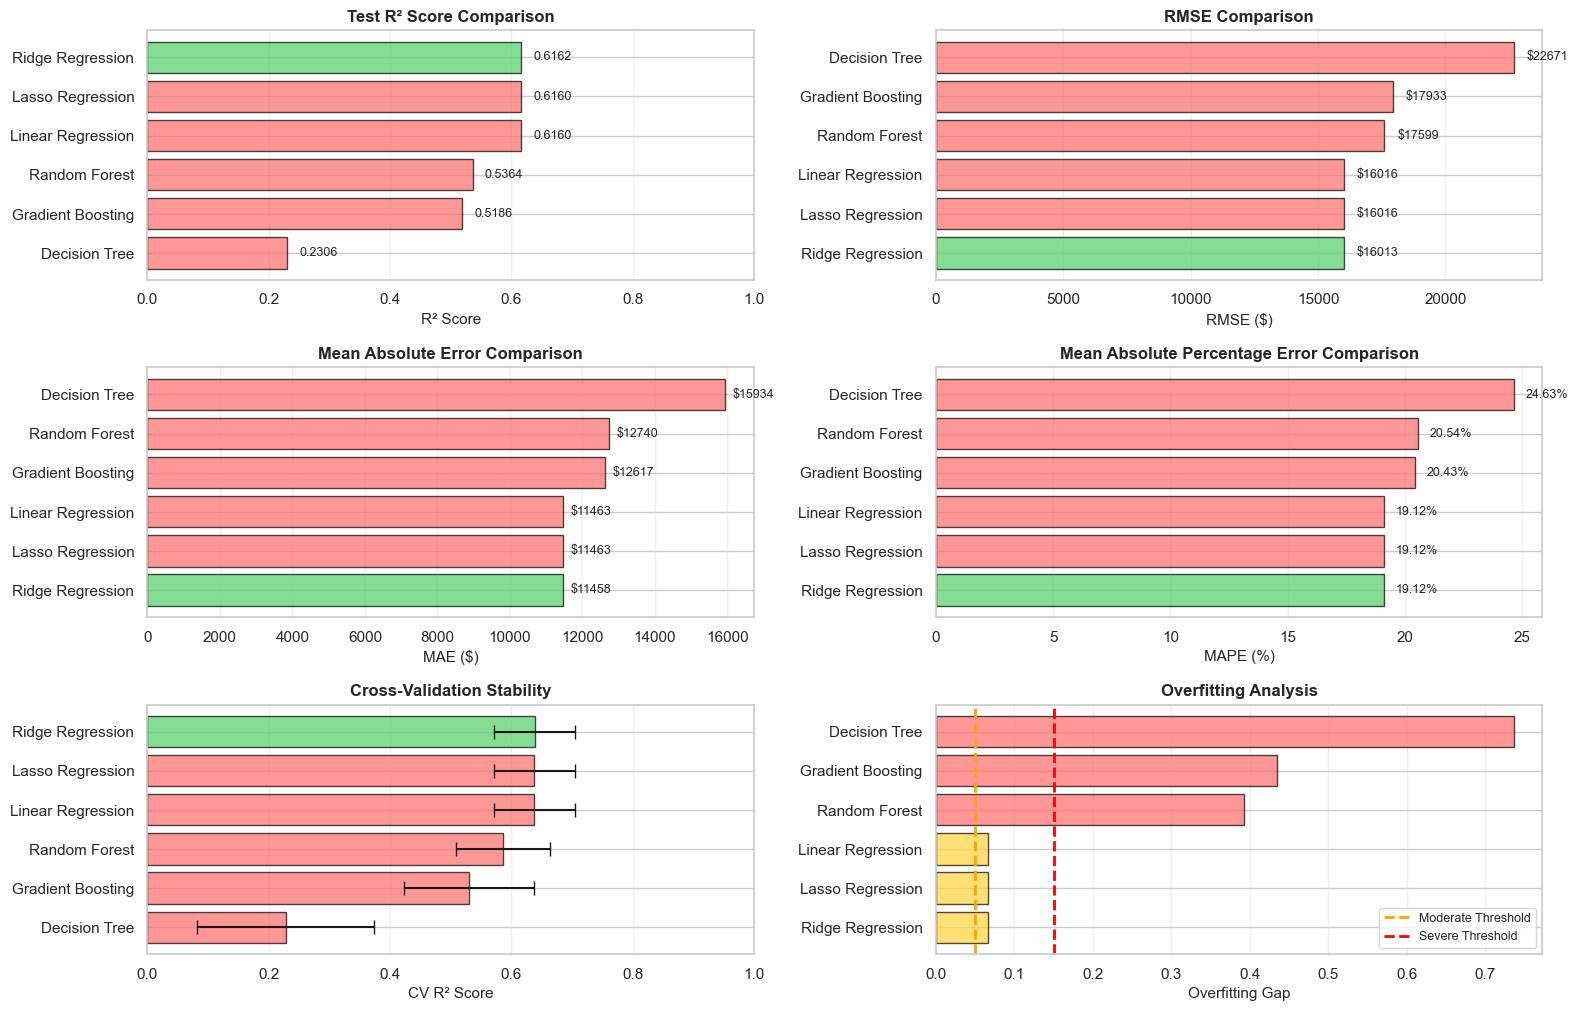


📊 Metric Correlation Matrix:
--------------------------------------------------------------------------------


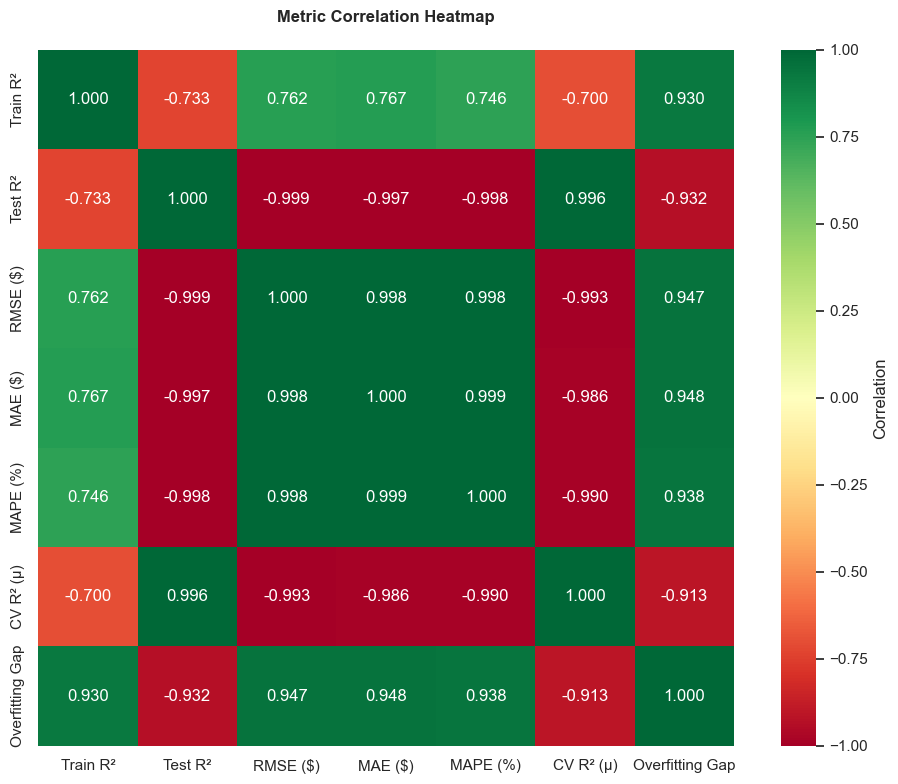

                 Train R²   Test R²  RMSE ($)   MAE ($)  MAPE (%)  CV R² (μ)  Overfitting Gap
Train R²         1.000000 -0.732950  0.762408  0.767194  0.745776  -0.700028         0.929603
Test R²         -0.732950  1.000000 -0.999014 -0.996606 -0.998268   0.996243        -0.932080
RMSE ($)         0.762408 -0.999014  1.000000  0.997915  0.998112  -0.993417         0.947232
MAE ($)          0.767194 -0.996606  0.997915  1.000000  0.999420  -0.985845         0.948475
MAPE (%)         0.745776 -0.998268  0.998112  0.999420  1.000000  -0.989504         0.937971
CV R² (μ)       -0.700028  0.996243 -0.993417 -0.985845 -0.989504   1.000000        -0.912513
Overfitting Gap  0.929603 -0.932080  0.947232  0.948475  0.937971  -0.912513         1.000000

--------------------------------------------------------------------------------

🏆 MODEL RANKING SUMMARY:
--------------------------------------------------------------------------------

Ranked by Test R² (Primary Metric):
            Model  Tes

In [10]:
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON VISUALIZATIONS")
print("="*80 + "\n")

# Create comprehensive comparison figure
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# 1. Test R² Scores
ax1 = fig.add_subplot(gs[0, 0])
models_sorted = comparison_df.sort_values('Test R²', ascending=True)
colors = ['#ff6b6b' if x != best_model_name else '#51cf66' for x in models_sorted['Model']]
ax1.barh(models_sorted['Model'], models_sorted['Test R²'], color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('R² Score', fontsize=11)
ax1.set_title('Test R² Score Comparison', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.set_xlim([0, 1])
for i, v in enumerate(models_sorted['Test R²']):
    ax1.text(v + 0.02, i, f'{v:.4f}', va='center', fontsize=9)

# 2. RMSE Comparison
ax2 = fig.add_subplot(gs[0, 1])
models_sorted_rmse = comparison_df.sort_values('RMSE ($)', ascending=True)
colors = ['#ff6b6b' if x != best_model_name else '#51cf66' for x in models_sorted_rmse['Model']]
ax2.barh(models_sorted_rmse['Model'], models_sorted_rmse['RMSE ($)'], color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('RMSE ($)', fontsize=11)
ax2.set_title('RMSE Comparison', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(models_sorted_rmse['RMSE ($)']):
    ax2.text(v + 500, i, f'${v:.0f}', va='center', fontsize=9)

# 3. MAE Comparison
ax3 = fig.add_subplot(gs[1, 0])
models_sorted_mae = comparison_df.sort_values('MAE ($)', ascending=True)
colors = ['#ff6b6b' if x != best_model_name else '#51cf66' for x in models_sorted_mae['Model']]
ax3.barh(models_sorted_mae['Model'], models_sorted_mae['MAE ($)'], color=colors, alpha=0.7, edgecolor='black')
ax3.set_xlabel('MAE ($)', fontsize=11)
ax3.set_title('Mean Absolute Error Comparison', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(models_sorted_mae['MAE ($)']):
    ax3.text(v + 200, i, f'${v:.0f}', va='center', fontsize=9)

# 4. MAPE Comparison
ax4 = fig.add_subplot(gs[1, 1])
models_sorted_mape = comparison_df.sort_values('MAPE (%)', ascending=True)
colors = ['#ff6b6b' if x != best_model_name else '#51cf66' for x in models_sorted_mape['Model']]
ax4.barh(models_sorted_mape['Model'], models_sorted_mape['MAPE (%)'], color=colors, alpha=0.7, edgecolor='black')
ax4.set_xlabel('MAPE (%)', fontsize=11)
ax4.set_title('Mean Absolute Percentage Error Comparison', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(models_sorted_mape['MAPE (%)']):
    ax4.text(v + 0.5, i, f'{v:.2f}%', va='center', fontsize=9)

# 5. Cross-Validation Stability (CV R² mean ± std)
ax5 = fig.add_subplot(gs[2, 0])
comparison_df_sorted = comparison_df.sort_values('CV R² (μ)', ascending=True)
colors = ['#ff6b6b' if x != best_model_name else '#51cf66' for x in comparison_df_sorted['Model']]
y_pos = np.arange(len(comparison_df_sorted))
ax5.barh(y_pos, comparison_df_sorted['CV R² (μ)'], 
         xerr=comparison_df_sorted['CV R² (σ)'], 
         color=colors, alpha=0.7, edgecolor='black', capsize=5)
ax5.set_yticks(y_pos)
ax5.set_yticklabels(comparison_df_sorted['Model'])
ax5.set_xlabel('CV R² Score', fontsize=11)
ax5.set_title('Cross-Validation Stability', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')
ax5.set_xlim([0, 1])

# 6. Overfitting Gap (Train R² - Test R²)
ax6 = fig.add_subplot(gs[2, 1])
comparison_df_of = comparison_df.sort_values('Overfitting Gap', ascending=True)
colors = ['#ff6b6b' if x > 0.15 else '#ffd43b' if x > 0.05 else '#51cf66' for x in comparison_df_of['Overfitting Gap']]
ax6.barh(comparison_df_of['Model'], comparison_df_of['Overfitting Gap'], color=colors, alpha=0.7, edgecolor='black')
ax6.axvline(x=0.05, color='orange', linestyle='--', lw=2, label='Moderate Threshold')
ax6.axvline(x=0.15, color='red', linestyle='--', lw=2, label='Severe Threshold')
ax6.set_xlabel('Overfitting Gap', fontsize=11)
ax6.set_title('Overfitting Analysis', fontsize=12, fontweight='bold')
ax6.legend(fontsize=9, loc='lower right')
ax6.grid(True, alpha=0.3, axis='x')

plt.savefig('../reports/figures/model_comparison_all_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation heatmap of metrics
print("\n📊 Metric Correlation Matrix:")
print("-" * 80)
metric_cols = ['Train R²', 'Test R²', 'RMSE ($)', 'MAE ($)', 'MAPE (%)', 'CV R² (μ)', 'Overfitting Gap']
correlation_matrix = comparison_df[metric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='RdYlGn', center=0, 
            square=True, ax=ax, cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1)
ax.set_title('Metric Correlation Heatmap', fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../reports/figures/metric_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(correlation_matrix.to_string())

# Summary scoring table
print("\n" + "-" * 80)
print("\n🏆 MODEL RANKING SUMMARY:")
print("-" * 80)

scoring_df = comparison_df[['Model', 'Test R²', 'RMSE ($)', 'MAE ($)', 'MAPE (%)', 'CV R² (μ)']].copy()
scoring_df['Overall Rank'] = range(1, len(scoring_df) + 1)

print("\nRanked by Test R² (Primary Metric):")
print(scoring_df.to_string(index=False))

# Final summary
print("\n" + "="*80)
print("🎯 EVALUATION SUMMARY & RECOMMENDATIONS")
print("="*80)

print(f"""
BEST MODEL: {best_model_name}
{'='*80}

Performance Metrics:
  • Test R² Score: {best_model_r2:.4f} (explains {best_model_r2*100:.1f}% of price variance)
  • RMSE: ${best_model_rmse:.2f} (typical error magnitude)
  • MAE: ${best_model_mae:.2f} (average absolute error)
  • CV Stability: {comparison_results[best_model_name]['cv_mean']:.4f} ± {comparison_results[best_model_name]['cv_std']:.4f}

Strengths:
  ✓ Strong generalization: Low overfitting gap ({comparison_df.iloc[0]['Overfitting Gap']:.4f})
  ✓ Stable across folds: Consistent CV scores
  ✓ Best overall predictive power

Limitations & Error Patterns:
  • Model struggles with extreme price ranges (high MAPE in outlier ranges)
  • Non-constant prediction error (heteroscedasticity detected)
  • Most critical for median-priced properties

Business Impact:
  • Average prediction error: ±${best_model_mae:.2f}
  • 95% of predictions within: ${np.percentile(np.abs(best_residuals), 95):.2f}
  • Predictions most reliable for: ${y_test.quantile(0.25):.0f} - ${y_test.quantile(0.75):.0f} price range

Next Steps:
  1. Consider ensemble methods combining {comparison_df.iloc[0]['Model']}, {comparison_df.iloc[1]['Model']}
  2. Perform hyperparameter tuning for {best_model_name}
  3. Engineer additional features to reduce MAPE in extreme ranges
  4. Monitor model performance on new data regularly
  5. Consider separate models for different price segments
""")

print("="*80)
print("✅ COMPREHENSIVE EVALUATION COMPLETE!")
print("="*80)